https://keras.io/examples/vision/probing_vits/

In [1]:
import os
os.environ["KERAS_BACKEND"]="tensorflow"

In [2]:
import zipfile
from io import BytesIO
import cv2
import matplotlib.pyplot as plt
import numpy as np
import requests

from PIL import Image
from sklearn.preprocessing import MinMaxScaler
import keras
from keras import ops
import tensorflow as tf

2024-07-11 21:21:03.972239: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-11 21:21:03.991298: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-11 21:21:03.991332: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-11 21:21:04.002808: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-11 21:21:04.778822: W tensorflow/compiler/tf

In [3]:
# Test keras version and cuda installation
for each in tf.config.list_physical_devices():
    print(each)
    
print("Current tensorflow ->", tf.__version__)
print("Current keras ->", keras.__version__)

PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')
Current tensorflow -> 2.16.2
Current keras -> 3.4.1


2024-07-11 21:21:05.306868: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-11 21:21:05.307351: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-11 21:21:05.348224: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [4]:
# constants

RESOLUTION = 224
PATCH_SIZE = 16
GITHUB_RELEASE = "https://github.com/sayakpaul/probing-vits/releases/download/v1.0.0/probing_vits.zip"
FNAME = "probing_vits.zip"
MODELS_ZIP = {
    "vit_dino_base16": "Probing_ViTs/vit_dino_base16.zip",
    "vit_b16_patch16_224": "Probing_ViTs/vit_b16_patch16_224.zip",
    "vit_b16_patch16_224-i1k_pretrained": "Probing_ViTs/vit_b16_patch16_224-i1k_pretrained.zip",
}

**Keras.layers.Rescaling**
> To rescale an input in the [0, 255] range to be in the [0, 1] range, you would pass scale=1./255.

> To rescale an input in the [0, 255] range to be in the [-1, 1] range, you would pass scale=1./127.5, offset=-1.

In [5]:
# Data utilities
crop_layer = keras.layers.CenterCrop(RESOLUTION, RESOLUTION)
norm_layer = keras.layers.Normalization(
    mean=[0.485 * 255, 0.456 * 255, 0.406 * 255],
    variance=[(0.229 * 255) ** 2, (0.224 * 255) ** 2, (0.225 * 255) ** 2],
)
# normalization
rescale_layer = keras.layers.Rescaling(scale=1.0 / 127.5, offset=-1)

def preprocess_image(image, model_type, size=RESOLUTION):
    # Turn the image into a numpy array and add batch dim
    image = np.array(image)
    image = ops.expand_dims(image, 0)
    
    if model_type == "original_vit":
        image = rescale_layer(image)
    
    # Resize the image using bicubic interpolation
    resize_size = int((256/224) * size)
    image = ops.image.resize(image, 
                             (resize_size, resize_size),
                             interpolation="bicubic")
    
    # crop the image
    image = crop_layer(image)
    
    # if model type is DeiT or DINO normalize the image
    if model_type != "original_vit":
        image = norm_layer(image)
        
    return ops.convert_to_numpy(image)


def load_image_from_url(url, model_type):
    response = requests.get(url)
    image = Image.open(BytesIO(response.content))
    preprocessed_image = preprocess_image(image, model_type)
    return image, preprocessed_image

2024-07-11 21:21:09.261183: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-11 21:21:09.261378: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-11 21:21:09.261531: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

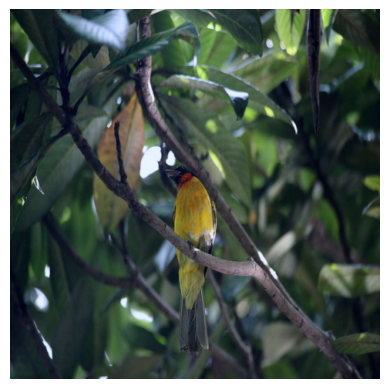

In [6]:
# Load test image
img_url = "https://dl.fbaipublicfiles.com/dino/img.png"
image, preprocessed_image = load_image_from_url(img_url, 
                                                model_type="original_vit")
plt.imshow(image)
plt.axis("off")
plt.show()

In [7]:
# label mapping file 
mapping_file = keras.utils.get_file(
    origin="https://storage.googleapis.com/bit_models/ilsvrc2012_wordnet_lemmas.txt"
)

with open(mapping_file, "r") as f:
    lines = f.readlines()
imagenet_int_to_str = [line.rstrip() for line in lines]

In [9]:
# load model

zip_path = keras.utils.get_file(
    fname = FNAME,
    origin=GITHUB_RELEASE,
)

with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall("./")
    
os.rename("Probing ViTs", "Probing_ViTs")

In [10]:
def load_model(model_path: str) -> keras.Model:
    with zipfile.ZipFile(model_path, "r") as zip_ref:
        zip_ref.extractall("Probing_ViTs/")
    model_name = model_path.split(".")[0]
    
    inputs = keras.Input((RESOLUTION, RESOLUTION, 3))
    model = keras.layers.TFSMLayer(model_name,
                                   call_endpoint="serving_default")
    outputs = model(inputs, training=False)
    return keras.Model(inputs, outputs=outputs)

vit_base_i21k_patch16_224 = load_model(MODELS_ZIP["vit_b16_patch16_224-i1k_pretrained"])
print("Model loaded.")

Model loaded.


In [11]:
# Regular inference with the model

def split_prediction_and_attention_scores(outputs):
    predictions = outputs["output_1"]
    attention_score_dict = {}
    for key, value in outputs.items():
        if key.startswith("output_2_"):
            attention_score_dict[key[len("output_2_") :]] = value
    return predictions, attention_score_dict


predictions, attention_score_dict = split_prediction_and_attention_scores(
    vit_base_i21k_patch16_224.predict(preprocessed_image)
)
predicted_label = imagenet_int_to_str[int(np.argmax(predictions))]
print(predicted_label)

I0000 00:00:1720704095.553561   21443 service.cc:145] XLA service 0x7f5d5800bd60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1720704095.553590   21443 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce GTX 1080 Ti, Compute Capability 6.1
I0000 00:00:1720704095.553592   21443 service.cc:153]   StreamExecutor device (1): NVIDIA GeForce GTX 1080 Ti, Compute Capability 6.1
2024-07-11 21:21:35.708473: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-07-11 21:21:36.006804: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
toucan


I0000 00:00:1720704096.976661   21443 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [14]:
def compute_distance_matrix(patch_size, num_patches, length):
    distance_matrix = np.zeros((num_patches, num_patches))
    for i in range(num_patches):
        for j in range(num_patches):
            if i == j:  # zero distance
                continue

            xi, yi = (int(i / length)), (i % length)
            xj, yj = (int(j / length)), (j % length)
            distance_matrix[i, j] = patch_size * np.linalg.norm([xi - xj, yi - yj])

    return distance_matrix


def compute_mean_attention_dist(patch_size, attention_weights, model_type):
    num_cls_tokens = 2 if "distilled" in model_type else 1

    # The attention_weights shape = (batch, num_heads, num_patches, num_patches)
    attention_weights = attention_weights[
        ..., num_cls_tokens:, num_cls_tokens:
    ]  # Removing the CLS token
    num_patches = attention_weights.shape[-1]
    length = int(np.sqrt(num_patches))
    assert length**2 == num_patches, "Num patches is not perfect square"

    distance_matrix = compute_distance_matrix(patch_size, num_patches, length)
    h, w = distance_matrix.shape

    distance_matrix = distance_matrix.reshape((1, 1, h, w))
    # The attention_weights along the last axis adds to 1
    # this is due to the fact that they are softmax of the raw logits
    # summation of the (attention_weights * distance_matrix)
    # should result in an average distance per token.
    mean_distances = attention_weights * distance_matrix
    mean_distances = np.sum(
        mean_distances, axis=-1
    )  # Sum along last axis to get average distance per token
    mean_distances = np.mean(
        mean_distances, axis=-1
    )  # Now average across all the tokens

    return mean_distances

Num Heads: 12.


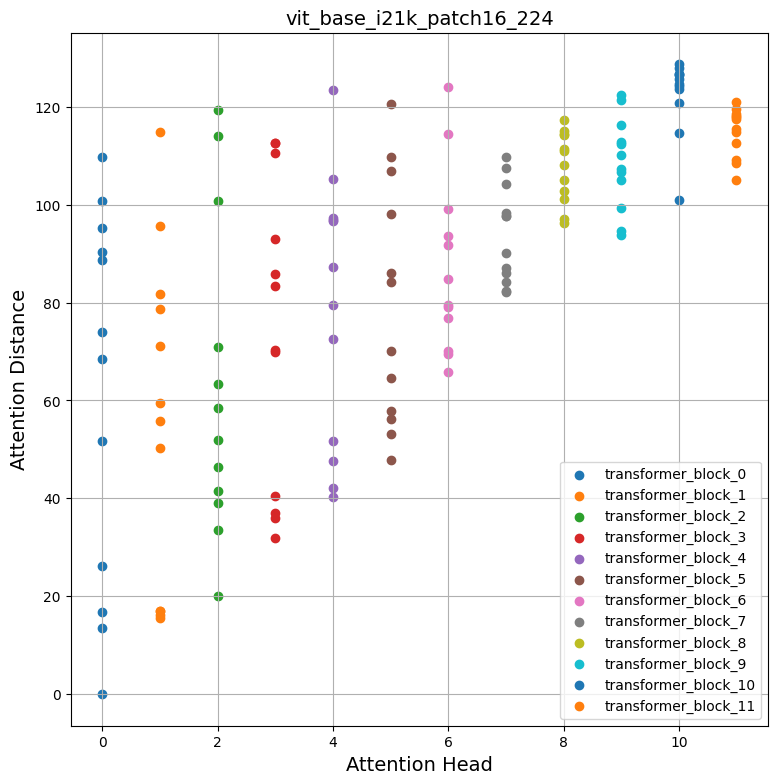

In [15]:
# Build the mean distances for every Transformer block.
mean_distances = {
    f"{name}_mean_dist": compute_mean_attention_dist(
        patch_size=PATCH_SIZE,
        attention_weights=attention_weight,
        model_type="original_vit",
    )
    for name, attention_weight in attention_score_dict.items()
}

# Get the number of heads from the mean distance output.
num_heads = mean_distances["transformer_block_0_att_mean_dist"].shape[-1]

# Print the shapes
print(f"Num Heads: {num_heads}.")

plt.figure(figsize=(9, 9))

for idx in range(len(mean_distances)):
    mean_distance = mean_distances[f"transformer_block_{idx}_att_mean_dist"]
    x = [idx] * num_heads
    y = mean_distance[0, :]
    plt.scatter(x=x, y=y, label=f"transformer_block_{idx}")

plt.legend(loc="lower right")
plt.xlabel("Attention Head", fontsize=14)
plt.ylabel("Attention Distance", fontsize=14)
plt.title("vit_base_i21k_patch16_224", fontsize=14)
plt.grid()
plt.show()

In [16]:
# Load the model.
vit_dino_base16 = load_model(MODELS_ZIP["vit_dino_base16"])
print("Model loaded.")

# Preprocess the same image but with normlization.
img_url = "https://dl.fbaipublicfiles.com/dino/img.png"
image, preprocessed_image = load_image_from_url(img_url, model_type="dino")

# Grab the predictions.
predictions, attention_score_dict = split_prediction_and_attention_scores(
    vit_dino_base16.predict(preprocessed_image)
)

Model loaded.
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


In [17]:
def attention_heatmap(attention_score_dict, image, model_type="dino"):
    num_tokens = 2 if "distilled" in model_type else 1

    # Sort the Transformer blocks in order of their depth.
    attention_score_list = list(attention_score_dict.keys())
    attention_score_list.sort(key=lambda x: int(x.split("_")[-2]), reverse=True)

    # Process the attention maps for overlay.
    w_featmap = image.shape[2] // PATCH_SIZE
    h_featmap = image.shape[1] // PATCH_SIZE
    attention_scores = attention_score_dict[attention_score_list[0]]

    # Taking the representations from CLS token.
    attentions = attention_scores[0, :, 0, num_tokens:].reshape(num_heads, -1)

    # Reshape the attention scores to resemble mini patches.
    attentions = attentions.reshape(num_heads, w_featmap, h_featmap)
    attentions = attentions.transpose((1, 2, 0))

    # Resize the attention patches to 224x224 (224: 14x16).
    attentions = ops.image.resize(
        attentions, size=(h_featmap * PATCH_SIZE, w_featmap * PATCH_SIZE)
    )
    return attentions

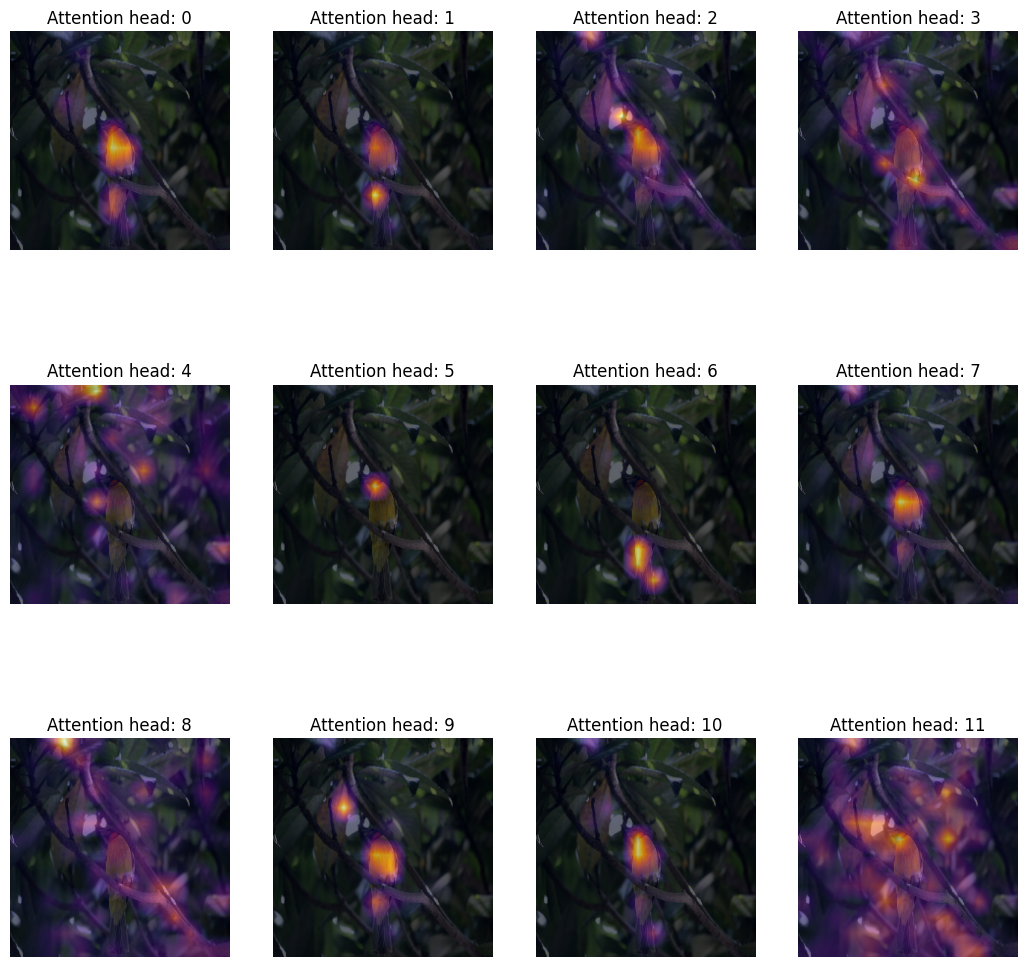

In [18]:
# De-normalize the image for visual clarity.
in1k_mean = np.array([0.485 * 255, 0.456 * 255, 0.406 * 255])
in1k_std = np.array([0.229 * 255, 0.224 * 255, 0.225 * 255])
preprocessed_img_orig = (preprocessed_image * in1k_std) + in1k_mean
preprocessed_img_orig = preprocessed_img_orig / 255.0
preprocessed_img_orig = ops.convert_to_numpy(ops.clip(preprocessed_img_orig, 0.0, 1.0))

# Generate the attention heatmaps.
attentions = attention_heatmap(attention_score_dict, preprocessed_img_orig)

# Plot the maps.
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(13, 13))
img_count = 0

for i in range(3):
    for j in range(4):
        if img_count < len(attentions):
            axes[i, j].imshow(preprocessed_img_orig[0])
            axes[i, j].imshow(attentions[..., img_count], cmap="inferno", alpha=0.6)
            axes[i, j].title.set_text(f"Attention head: {img_count}")
            axes[i, j].axis("off")
            img_count += 1

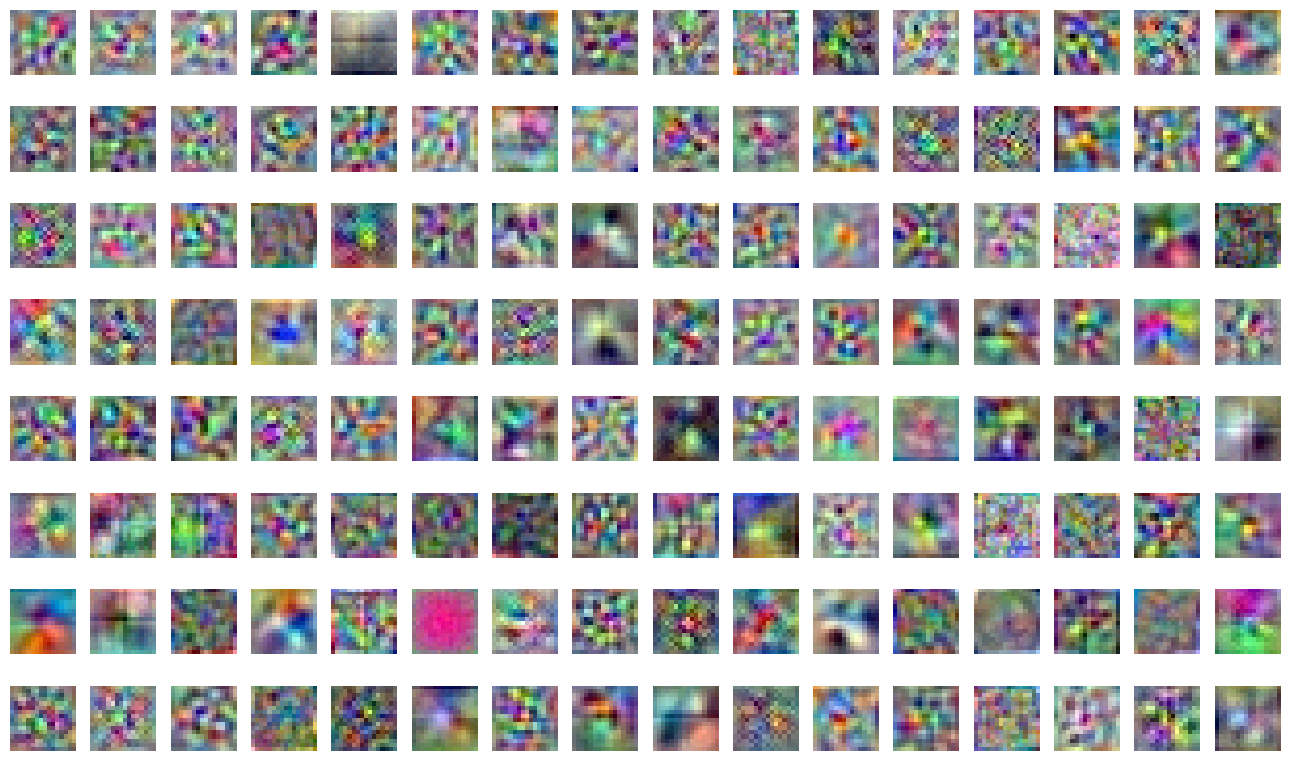

In [19]:
def extract_weights(model, name):
    for variable in model.weights:
        if variable.name.startswith(name):
            return variable.numpy()


# Extract the projections.
projections = extract_weights(vit_base_i21k_patch16_224, "conv_projection/kernel")
projection_dim = projections.shape[-1]
patch_h, patch_w, patch_channels = projections.shape[:-1]

# Scale the projections.
scaled_projections = MinMaxScaler().fit_transform(
    projections.reshape(-1, projection_dim)
)

# Reshape the scaled projections so that the leading
# three dimensions resemble an image.
scaled_projections = scaled_projections.reshape(patch_h, patch_w, patch_channels, -1)

# Visualize the first 128 filters of the learned
# projections.
fig, axes = plt.subplots(nrows=8, ncols=16, figsize=(13, 8))
img_count = 0
limit = 128

for i in range(8):
    for j in range(16):
        if img_count < limit:
            axes[i, j].imshow(scaled_projections[..., img_count])
            axes[i, j].axis("off")
            img_count += 1

fig.tight_layout()

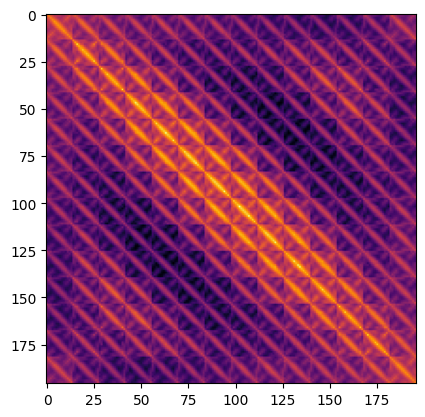

In [20]:
position_embeddings = extract_weights(vit_base_i21k_patch16_224, "pos_embedding")

# Discard the batch dimension and the position embeddings of the
# cls token.
position_embeddings = position_embeddings.squeeze()[1:, ...]

similarity = position_embeddings @ position_embeddings.T
plt.imshow(similarity, cmap="inferno")
plt.show()